# Enhanced GLiNER Evaluation: Zero-Shot vs Few-Shot on Serbian Legal Documents

This notebook evaluates GLiNER (Generalist and Lightweight Named Entity Recognition) with **enhanced configurations** on 225 Serbian legal documents to compare with fine-tuned BCSm-BERTić results.

## 🚀 **Key Improvements:**
- **Natural Language Labels**: Human-readable entity descriptions instead of abbreviations
- **Multilingual Model**: `urchade/gliner_multilingual_base` for better Serbian support
- **Zero-Shot vs Few-Shot**: Compare both approaches on the same dataset
- **Optimized Entity Types**: Better descriptions for legal domain

## 🏷️ **Enhanced Entity Types:**
- `legal court or tribunal` → COURT
- `judge or judicial officer` → JUDGE  
- `defendant or accused person` → DEFENDANT
- `penalty amount or duration` → SANCTION_VALUE
- `case number identifier` → CASE_NUMBER
- And more natural descriptions for better GLiNER performance...

In [1]:
# Install GLiNER if not already installed
!pip install gliner[gpu]
!pip install seqeval scikit-learn matplotlib seaborn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import required libraries
import json
import os
import random
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from collections import Counter, defaultdict
import time

# Data processing
import pandas as pd
import numpy as np
from tqdm import tqdm

# GLiNER
from gliner import GLiNER

# Evaluation metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score
from seqeval.scheme import IOB2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# 🚀 Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"🚀 GPU available: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ GPU not available - will use CPU (slower)")

print("✅ All dependencies loaded successfully!")
print(f"🌟 Ready for GLiNER zero-shot evaluation!")

🚀 GPU available: Tesla T4
💾 GPU memory: 15.8 GB
✅ All dependencies loaded successfully!
🌟 Ready for GLiNER zero-shot evaluation!


In [4]:
# Configuration
LABELSTUDIO_JSON_PATH = "/content/drive/MyDrive/NER_Master/annotations.json"
JUDGMENTS_DIR = "/content/drive/MyDrive/NER_Master/judgments"
MAX_EXAMPLES = 225  # Evaluate on all available documents
CONFIDENCE_THRESHOLD = 0.3  # GLiNER confidence threshold

# Serbian Legal Entity Types for GLiNER
LEGAL_ENTITY_TYPES = [
    "court or tribunal",                    # COURT
    "date of decision or judgment",         # DECISION_DATE
    "case number or case identifier",       # CASE_NUMBER
    "criminal act or offense",              # CRIMINAL_ACT
    "prosecutor or public attorney",        # PROSECUTOR
    "defendant or accused person",          # DEFENDANT
    "judge or judicial officer",            # JUDGE
    "court registrar or clerk",             # REGISTRAR
    "court verdict or ruling",              # VERDICT
    "type of sanction or penalty",          # SANCTION_TYPE
    "sanction amount or duration",          # SANCTION_VALUE
    "material legal provision or article",  # PROVISION_MATERIAL
    "procedural legal provision or article",# PROVISION_PROCEDURAL
    "legal procedure costs or fees"         # PROCEDURE_COSTS
]


# Enhanced mapping from natural language to ground truth labels
GLINER_TO_GT_MAPPING = {
    "court or tribunal": "COURT",
    "date of decision or judgment": "DECISION_DATE",
    "case number or case identifier": "CASE_NUMBER",
    "criminal act or offense": "CRIMINAL_ACT",
    "prosecutor or public attorney": "PROSECUTOR",
    "defendant or accused person": "DEFENDANT",
    "judge or judicial officer": "JUDGE",
    "court registrar or clerk": "REGISTRAR",
    "court verdict or ruling": "VERDICT",
    "type of sanction or penalty": "SANCTION_TYPE",
    "sanction amount or duration": "SANCTION_VALUE",
    "material legal provision or article": "PROVISION_MATERIAL",
    "procedural legal provision or article": "PROVISION_PROCEDURAL",
    "legal procedure costs or fees": "PROCEDURE_COSTS"
}

print(f"📋 Configured for evaluation on {MAX_EXAMPLES} documents")
print(f"🎯 Entity types: {len(LEGAL_ENTITY_TYPES)}")
print(f"⚡ Confidence threshold: {CONFIDENCE_THRESHOLD}")

📋 Configured for evaluation on 225 documents
🎯 Entity types: 14
⚡ Confidence threshold: 0.3


In [5]:
# Load LabelStudio annotations
print("📂 Loading LabelStudio annotations...")

try:
    with open(LABELSTUDIO_JSON_PATH, 'r', encoding='utf-8') as f:
        labelstudio_data = json.load(f)
    print(f"✅ Loaded {len(labelstudio_data)} annotated documents")
except FileNotFoundError:
    print(f"❌ Error: {LABELSTUDIO_JSON_PATH} not found!")
    print("Please ensure the annotations file is in the current directory.")
    raise

# Check available judgment files
judgment_files = list(Path(JUDGMENTS_DIR).glob('*.txt'))
print(f"📁 Available judgment files: {len(judgment_files)}")

if len(judgment_files) == 0:
    print(f"⚠️ Warning: No judgment files found in {JUDGMENTS_DIR}")
    print("Please ensure the labelstudio_files directory contains the text files.")

📂 Loading LabelStudio annotations...
✅ Loaded 225 annotated documents
📁 Available judgment files: 226


In [6]:
class GroundTruthLoader:
    """
    Load and prepare ground truth data from LabelStudio annotations
    for comparison with GLiNER zero-shot predictions.
    """

    def __init__(self, judgments_dir: str):
        self.judgments_dir = Path(judgments_dir)
        self.entity_types = set()

    def load_text_file(self, file_path: str) -> str:
        """Load text content from judgment file"""
        # Handle different file path formats from LabelStudio
        if "/" in file_path:
            filename = file_path.split("/")[-1]
        else:
            filename = file_path

        full_path = self.judgments_dir / filename

        if not full_path.exists():
            print(f"⚠️ File not found: {full_path}")
            return ""

        try:
            with open(full_path, 'r', encoding='utf-8') as f:
                return f.read().strip()
        except UnicodeDecodeError:
            try:
                with open(full_path, 'r', encoding='utf-8-sig') as f:
                    return f.read().strip()
            except Exception as e:
                print(f"❌ Error reading {full_path}: {e}")
                return ""

    def extract_ground_truth_entities(self, labelstudio_data: List[Dict]) -> List[Dict]:
        """Extract ground truth entities from LabelStudio annotations"""
        ground_truth_examples = []

        for item in tqdm(labelstudio_data, desc="Loading ground truth"):
            file_path = item.get("file_upload", "")
            text_content = self.load_text_file(file_path)

            if not text_content:
                continue

            annotations = item.get("annotations", [])

            for annotation in annotations:
                entities = []
                result = annotation.get("result", [])

                for res in result:
                    if res.get("type") == "labels":
                        value = res["value"]
                        start = value["start"]
                        end = value["end"]
                        labels = value["labels"]

                        for label in labels:
                            self.entity_types.add(label)
                            entities.append({
                                'text': text_content[start:end],
                                'label': label,
                                'start': start,
                                'end': end
                            })

                if entities:  # Only include documents with entities
                    ground_truth_examples.append({
                        'text': text_content,
                        'entities': entities,
                        'file_path': file_path
                    })

        print(f"✅ Loaded {len(ground_truth_examples)} examples with ground truth entities")
        print(f"🏷️ Found entity types: {sorted(self.entity_types)}")

        return ground_truth_examples

# Load ground truth data
print("📂 Loading ground truth annotations...")
gt_loader = GroundTruthLoader(JUDGMENTS_DIR)
ground_truth_examples = gt_loader.extract_ground_truth_entities(labelstudio_data)

print(f"\n📊 Ground Truth Statistics:")
print(f"  📄 Total examples: {len(ground_truth_examples)}")
print(f"  🏷️ Entity types: {len(gt_loader.entity_types)}")

# Show entity distribution
entity_counts = Counter()
for example in ground_truth_examples:
    for entity in example['entities']:
        entity_counts[entity['label']] += 1

print(f"\n📈 Entity Distribution:")
for entity_type, count in entity_counts.most_common():
    print(f"  {entity_type}: {count}")

📂 Loading ground truth annotations...


Loading ground truth: 100%|██████████| 225/225 [00:05<00:00, 41.39it/s] 

✅ Loaded 225 examples with ground truth entities
🏷️ Found entity types: ['CASE_NUMBER', 'COURT', 'CRIMINAL_ACT', 'DECISION_DATE', 'DEFENDANT', 'JUDGE', 'PROCEDURE_COSTS', 'PROSECUTOR', 'PROVISION_MATERIAL', 'PROVISION_PROCEDURAL', 'REGISTRAR', 'SANCTION_TYPE', 'SANCTION_VALUE', 'VERDICT']

📊 Ground Truth Statistics:
  📄 Total examples: 225
  🏷️ Entity types: 14

📈 Entity Distribution:
  DEFENDANT: 1240
  PROVISION_MATERIAL: 1177
  CRIMINAL_ACT: 792
  PROVISION_PROCEDURAL: 686
  REGISTRAR: 460
  COURT: 458
  JUDGE: 451
  PROSECUTOR: 395
  DECISION_DATE: 359
  SANCTION_TYPE: 248
  SANCTION_VALUE: 241
  VERDICT: 238
  PROCEDURE_COSTS: 231
  CASE_NUMBER: 225


In [ ]:
class GLiNERZeroShotEvaluator:
    """
    GLiNER Zero-Shot NER Evaluator for Serbian Legal Documents.

    This class implements true zero-shot evaluation using GLiNER models
    without any training on Serbian legal data.
    """

    def __init__(
        self,
        model_name: str = "urchade/gliner_multilingual_base",  # 🔄 Better model for few-shot
        confidence_threshold: float = 0.3,
    ):
        print(f"🌟 Initializing GLiNER Zero-Shot Evaluator: {model_name}")

        try:
            # Load GLiNER model
            self.model = GLiNER.from_pretrained(model_name)

            # 🚀 Enable GPU if available
            import torch

            if torch.cuda.is_available():
                self.model = self.model.cuda()
                print(f"🚀 GPU enabled: {torch.cuda.get_device_name(0)}")
            else:
                print("⚠️ GPU not available, using CPU")

            self.model_name = model_name
            self.confidence_threshold = confidence_threshold

            print(f"✅ GLiNER model loaded successfully")

        except Exception as e:
            print(f"❌ Error loading GLiNER model {model_name}: {e}")
            self.model = None

    def predict_entities(
        self, text: str, entity_types: List[str], examples: Optional[List[Dict]] = None
    ) -> List[Dict]:
        """
        Predict entities using GLiNER zero-shot or few-shot approach.

        Args:
            text: Input text to analyze
            entity_types: List of entity types to extract
            examples: Optional few-shot examples in GLiNER format:
                     [('example text', {'entity_type': ['entity1', 'entity2']}), ...]
        """
        if self.model is None:
            return []

        try:
            # Determine method based on examples
            method = "gliner_few_shot" if examples else "gliner_zero_shot"

            entities = self.model.predict_entities(
                text,
                entity_types,
                threshold=self.confidence_threshold,
                examples=examples,
            )

            # Convert to our format
            formatted_entities = []
            for entity in entities:
                formatted_entities.append(
                    {
                        "text": entity["text"],
                        "label": entity["label"],
                        "start": entity["start"],
                        "end": entity["end"],
                        "confidence": entity["score"],
                        "method": method,
                        "model": self.model_name,
                    }
                )

            return sorted(formatted_entities, key=lambda x: x["start"])

        except Exception as e:
            print(f"❌ Error in GLiNER prediction: {e}")
            return []

    def evaluate_on_dataset(
        self,
        ground_truth_examples: List[Dict],
        entity_types: List[str],
        max_examples: int = None,
    ) -> Dict:
        """
        Evaluate GLiNER on the ground truth dataset.
        """
        print(f"\n🧪 Starting GLiNER Zero-Shot Evaluation")
        print("=" * 60)

        if self.model is None:
            return {"error": "GLiNER model not loaded"}

        # Limit examples if specified
        eval_examples = (
            ground_truth_examples[:max_examples]
            if max_examples
            else ground_truth_examples
        )

        detailed_results = []
        prediction_counts = Counter()
        confidence_scores = []

        print(f"📊 Evaluating on {len(eval_examples)} examples...")

        start_time = time.time()

        for i, example in enumerate(tqdm(eval_examples, desc="GLiNER Evaluation")):
            text = example["text"]
            true_entities = example["entities"]

            # Get GLiNER predictions
            pred_entities = self.predict_entities(text, entity_types)

            # Count predictions by type
            for entity in pred_entities:
                prediction_counts[entity["label"]] += 1
                confidence_scores.append(entity["confidence"])

            # Store detailed results
            detailed_results.append(
                {
                    "example_id": i,
                    "text": text[:200] + "..." if len(text) > 200 else text,
                    "file_path": example["file_path"],
                    "true_entities": true_entities,
                    "pred_entities": pred_entities,
                    "true_count": len(true_entities),
                    "pred_count": len(pred_entities),
                }
            )

        end_time = time.time()
        evaluation_time = end_time - start_time

        # Calculate statistics
        total_true = sum(len(r["true_entities"]) for r in detailed_results)
        total_pred = sum(len(r["pred_entities"]) for r in detailed_results)
        avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.0

        print(f"\n📊 GLiNER Prediction Statistics:")
        for label, count in prediction_counts.most_common():
            print(f"  {label}: {count}")

        results = {
            "model_name": self.model_name,
            "confidence_threshold": self.confidence_threshold,
            "detailed_results": detailed_results,
            "total_true_entities": total_true,
            "total_pred_entities": total_pred,
            "prediction_counts": dict(prediction_counts),
            "examples_evaluated": len(eval_examples),
            "avg_confidence": avg_confidence,
            "evaluation_time": evaluation_time,
            "entities_per_second": (
                total_pred / evaluation_time if evaluation_time > 0 else 0
            ),
        }

        print(f"✅ GLiNER evaluation complete!")
        print(f"  📊 True entities: {total_true}")
        print(f"  🤖 Predicted entities: {total_pred}")
        print(f"  ⚡ Average confidence: {avg_confidence:.3f}")
        print(f"  ⏱️ Evaluation time: {evaluation_time:.2f}s")
        print(f"  🚀 Entities/second: {results['entities_per_second']:.2f}")

        return results

    # def evaluate_few_shot(
    #     self, ground_truth_examples, entity_types, num_examples_per_type=10
    # ):
    #     """
    #     Evaluate GLiNER with few-shot examples

    #     Args:
    #         ground_truth_examples: List of examples with 'text' and 'entities' keys
    #         entity_types: Dictionary mapping entity types to descriptions
    #         num_examples_per_type: Number of examples to use for few-shot
    #     """
    #     print(f"🎯 Starting Few-Shot GLiNER Evaluation...")
    #     print(f"📊 Dataset: {len(ground_truth_examples)} documents")
    #     print(f"🏷️ Entity types: {len(entity_types)}")
    #     print(f"📝 Examples for few-shot: {num_examples_per_type}")

    #     # Create few-shot examples
    #     # Create few-shot examples in correct GLiNER format: list of (text, dict_of_entities)
    #     import random

    #     selected_examples = random.sample(
    #         ground_truth_examples,
    #         min(num_examples_per_type, len(ground_truth_examples)),
    #     )

    #     few_shot_examples = []
    #     for example in selected_examples:
    #         text = example["text"]
    #         entities_dict = {}

    #         for entity in example["entities"]:
    #             gt_label = entity["label"]
    #             # Find corresponding natural language label
    #             natural_label = None
    #             for nl_label, gt_mapped in GLINER_TO_GT_MAPPING.items():
    #                 if gt_mapped == gt_label:
    #                     natural_label = nl_label
    #                     break

    #             if natural_label:
    #                 # GLiNER format: {entity_label: [list_of_entity_texts]}
    #                 if natural_label not in entities_dict:
    #                     entities_dict[natural_label] = []
    #                 entities_dict[natural_label].append(entity["text"])

    #         if entities_dict:
    #             # GLiNER format: (text, {label: [entity_texts]})
    #             few_shot_examples.append((text, entities_dict))
    #     print(
    #         f"✅ Created {len(few_shot_examples)} few-shot examples in correct GLiNER format"
    #     )
    #     if few_shot_examples:
    #         print(
    #             f"📝 Format: (text, dict) with {len(few_shot_examples[0][1])} entities in first example"
    #         )
    #         sample_entities = list(few_shot_examples[0][1].items())[:2]
    #         print(f"📋 Sample: {sample_entities}")

    #     # Handle entity_types as either dict or list
    #     if isinstance(entity_types, dict):
    #         entity_type_list = list(entity_types.keys())
    #     else:
    #         entity_type_list = entity_types  # Already a list

    #     print(f"🏷️ Using entity types: {entity_type_list}")

    #     # Evaluate using few-shot approach with actual few-shot examples
    #     print(
    #         f"🚀 Running TRUE few-shot evaluation with {len(few_shot_examples)} examples!"
    #     )

    #     return self._evaluate_with_few_shot_examples(
    #         ground_truth_examples, entity_type_list, few_shot_examples
    #     )

    # def _evaluate_with_few_shot_examples(
    #     self, ground_truth_examples, entity_types, few_shot_examples
    # ):
    #     """
    #     Evaluate GLiNER using few-shot examples as context
    #     """
    #     print(f"\n🧪 Starting GLiNER Few-Shot Evaluation")
    #     print("=" * 60)

    #     if self.model is None:
    #         return {"error": "GLiNER model not loaded"}

    #     detailed_results = []
    #     import time

    #     start_time = time.time()

    #     print(
    #         f"📊 Evaluating on {len(ground_truth_examples)} examples with few-shot context..."
    #     )

    #     # Process each example with few-shot context
    #     for i, example in enumerate(
    #         tqdm(ground_truth_examples, desc="GLiNER Few-Shot Evaluation")
    #     ):
    #         text = example["text"]
    #         true_entities = example["entities"]

    #         # Get predictions using few-shot examples
    #         pred_entities = self.predict_entities(
    #             text, entity_types, examples=few_shot_examples
    #         )

    #         # Store detailed results
    #         detailed_results.append(
    #             {
    #                 "example_id": i,
    #                 "text": text,
    #                 "true_entities": true_entities,
    #                 "pred_entities": pred_entities,
    #                 "method": "gliner_few_shot",
    #             }
    #         )

    #     evaluation_time = time.time() - start_time

    #     # Calculate metrics using existing evaluation logic
    #     total_true = sum(len(r["true_entities"]) for r in detailed_results)
    #     total_pred = sum(len(r["pred_entities"]) for r in detailed_results)

    #     # Calculate confidence statistics
    #     all_confidences = []
    #     for result in detailed_results:
    #         for entity in result["pred_entities"]:
    #             if "confidence" in entity:
    #                 all_confidences.append(entity["confidence"])

    #     avg_confidence = (
    #         sum(all_confidences) / len(all_confidences) if all_confidences else 0.0
    #     )

    #     # Count predictions by entity type
    #     from collections import Counter

    #     prediction_counts = Counter()
    #     for result in detailed_results:
    #         for entity in result["pred_entities"]:
    #             prediction_counts[entity["label"]] += 1

    #     # Prepare results
    #     results = {
    #         "detailed_results": detailed_results,
    #         "total_true_entities": total_true,
    #         "total_pred_entities": total_pred,
    #         "prediction_counts": dict(prediction_counts),
    #         "examples_evaluated": len(ground_truth_examples),
    #         "avg_confidence": avg_confidence,
    #         "evaluation_time": evaluation_time,
    #         "entities_per_second": (
    #             total_pred / evaluation_time if evaluation_time > 0 else 0
    #         ),
    #         "method": "gliner_few_shot",
    #         "few_shot_examples_used": len(few_shot_examples),
    #     }

    #     print(f"✅ GLiNER Few-Shot evaluation complete!")
    #     print(f"  📊 True entities: {total_true}")
    #     print(f"  🤖 Predicted entities: {total_pred}")
    #     print(f"  📚 Few-shot examples used: {len(few_shot_examples)}")
    #     print(f"  ⚡ Average confidence: {avg_confidence:.3f}")
    #     print(f"  ⏱️ Evaluation time: {evaluation_time:.2f}s")
    #     print(f"  🚀 Entities/second: {results['entities_per_second']:.2f}")

    #     return results

    # def _create_enhanced_entity_types_with_examples(self, entity_types, examples):
    #     """
    #     Create enhanced entity type descriptions with few-shot examples as context
    #     """
    #     enhanced_types = []

    #     for entity_type in entity_types:
    #         # Find examples for this entity type
    #         type_examples = []
    #         for example in examples:
    #             for entity in example.get("entities", []):
    #                 if entity.get("label") == entity_type:
    #                     type_examples.append(entity["text"])
    #                     if len(type_examples) >= 2:  # Limit to 2 examples per type
    #                         break
    #             if len(type_examples) >= 2:
    #                 break

    #         # Create enhanced description with examples
    #         if type_examples:
    #             examples_text = ", ".join(f'"{ex}"' for ex in type_examples[:2])
    #             enhanced_type = f"{entity_type} (examples: {examples_text})"
    #         else:
    #             enhanced_type = entity_type

    #         enhanced_types.append(enhanced_type)

    #     return enhanced_types



🚀 Initializing GLiNER Zero-Shot Evaluator...
🌟 Initializing GLiNER Zero-Shot Evaluator: urchade/gliner_multi


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/153 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

gliner_config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


🚀 GPU enabled: Tesla T4
✅ GLiNER model loaded successfully
🎯 Confidence threshold: 0.3


In [ ]:

class AdvancedFewShotBuilder:
    """
    Advanced few-shot example builder with stratification and diversity.
    """
    
    def __init__(self, label_mapping: dict, seed: int = 42):
        self.label_mapping = label_mapping
        self.seed = seed
        import random
        random.seed(seed)
    
    def build_stratified_examples(self, ground_truth_examples: list, 
                                entity_types: list, 
                                examples_per_type: int = 15,
                                max_text_length: int = 800) -> list:
        """
        Build stratified few-shot examples with diversity.
        
        Args:
            ground_truth_examples: List of annotated examples
            entity_types: List of entity type labels
            examples_per_type: Number of examples per entity type
            max_text_length: Maximum text length for examples
        
        Returns:
            List of (text, entities_dict) tuples in GLiNER format
        """
        import random
        from collections import defaultdict
        
        print(f"🔧 Building stratified few-shot examples...")
        print(f"📊 Target: {examples_per_type} examples per type")
        
        # Debug: Check what labels exist in ground truth
        all_gt_labels = set()
        for example in ground_truth_examples[:10]:  # Check first 10 examples
            for entity in example['entities']:
                all_gt_labels.add(entity['label'])
        print(f"🔍 Found GT labels: {sorted(all_gt_labels)}")
        print(f"🔍 Expected mapping: {list(self.label_mapping.values())}")
        
        # Group examples by entity types they contain
        examples_by_type = defaultdict(list)
        
        for example in ground_truth_examples:
            # Skip very long texts
            if len(example['text']) > max_text_length * 2:
                continue
                
            entity_types_in_example = set()
            for entity in example['entities']:
                gt_label = entity['label']
                # Map ground truth label to natural language
                for nl_label, mapped_gt_label in self.label_mapping.items():
                    if mapped_gt_label == gt_label:
                        entity_types_in_example.add(nl_label)
                        break
            
            # Add example to all relevant entity type buckets
            for entity_type in entity_types_in_example:
                if entity_type in entity_types:
                    examples_by_type[entity_type].append(example)
        
        # Sample diverse examples for each type
        selected_examples = []
        used_texts = set()
        
        # Debug: Show what was found
        print(f"🔍 Examples found by type: {dict((k, len(v)) for k, v in examples_by_type.items())}")
        
        for entity_type in entity_types:
            if entity_type not in examples_by_type:
                print(f"⚠️ No examples found for {entity_type}")
                continue
            
            candidates = examples_by_type[entity_type]
            
            # Sort by diversity metrics (text length, entity count)
            candidates = sorted(candidates, key=lambda x: (
                len(x['entities']),  # Prefer examples with more entities
                -len(x['text'])       # Prefer shorter texts (negative for reverse)
            ), reverse=True)
            
            # Select diverse examples
            selected_for_type = 0
            for candidate in candidates:
                if selected_for_type >= examples_per_type:
                    break
                
                # Avoid duplicate texts
                text_key = candidate['text'][:200]  # Use first 200 chars as key
                if text_key in used_texts:
                    continue
                
                # Truncate long texts
                text = candidate['text']
                if len(text) > max_text_length:
                    text = text[:max_text_length] + "..."
                
                # Build entities dict for this example
                entities_dict = {}
                for entity in candidate['entities']:
                    # Map to natural language label
                    for nl_label, gt_label in self.label_mapping.items():
                        if gt_label == entity['label']:
                            if nl_label not in entities_dict:
                                entities_dict[nl_label] = []
                            entities_dict[nl_label].append(entity['text'])
                
                if entities_dict:  # Only add if has entities
                    selected_examples.append((text, entities_dict))
                    used_texts.add(text_key)
                    selected_for_type += 1
            
            print(f"  📝 {entity_type}: {selected_for_type} examples")
        
        # Shuffle to avoid type-based ordering
        random.shuffle(selected_examples)
        
        print(f"✅ Built {len(selected_examples)} diverse few-shot examples")
        return selected_examples
    
    def build_dynamic_examples(self, input_text: str, ground_truth_examples: list,
                             entity_types: list, num_examples: int = 5) -> list:
        """
        Build dynamic few-shot examples relevant to the input text.
        
        Args:
            input_text: The text to find relevant examples for
            ground_truth_examples: Pool of examples to select from
            entity_types: List of entity types to focus on
            num_examples: Number of examples to select
        
        Returns:
            List of (text, entities_dict) tuples most relevant to input
        """
        import random
        from collections import defaultdict
        
        # Simple keyword-based relevance scoring
        input_keywords = set(input_text.lower().split())
        scored_examples = []
        
        for example in ground_truth_examples:
            example_keywords = set(example['text'].lower().split())
            overlap = len(input_keywords & example_keywords)
            
            # Build entities dict for this example
            entities_dict = {}
            for entity in example['entities']:
                # Map to natural language label
                for nl_label, gt_label in self.label_mapping.items():
                    if gt_label == entity['label']:
                        if nl_label not in entities_dict:
                            entities_dict[nl_label] = []
                        entities_dict[nl_label].append(entity['text'])
            
            if entities_dict:  # Only consider examples with entities
                score = overlap + len(entities_dict) * 2  # Bonus for entity diversity
                scored_examples.append((score, example['text'][:600], entities_dict))
        
        # Sort by relevance score and select top examples
        scored_examples.sort(key=lambda x: x[0], reverse=True)
        
        selected = [(text, entities) for _, text, entities in scored_examples[:num_examples]]
        return selected


# Initialize few-shot builder
few_shot_builder = AdvancedFewShotBuilder(GLINER_TO_GT_MAPPING, seed=42)


# 📚 HIGH-QUALITY MANUAL EXAMPLES LOADER
def load_manual_few_shot_examples():
    """
    Load manually crafted, high-quality Serbian legal examples.
    These are diverse, well-annotated examples covering different case types.
    """
    import os
    
    examples_dir = "few_shot_examples"
    manual_examples = []
    
    # Define manual annotations for each example file
    manual_annotations = {
        "example_01_theft.txt": {
            "court or tribunal": ["OSNOVNI SUD U BEOGRADU", "Osnovni sud u Beogradu"],
            "case number or case identifier": ["K. br. 245/23"],
            "judge or judicial officer": ["Marija Nikolić"],
            "court registrar or clerk": ["Ane Stojanović"],
            "defendant or accused person": ["MILOŠA PETROVIĆA", "MILOŠ PETROVIĆ"],
            "prosecutor or public attorney": ["Dragana Milovanovića"],
            "criminal act or offense": ["krađe"],
            "material legal provision or article": ["člana 203. stav 1. Krivičnog zakonika"],
            "type of sanction or penalty": ["novčanu kaznu"],
            "sanction amount or duration": ["30.000 dinara"],
            "legal procedure costs or fees": ["5.000 dinara"]
        },
        "example_02_assault.txt": {
            "court or tribunal": ["VIŠI SUD U NOVOM SADU", "Viši sud u Novom Sadu"],
            "case number or case identifier": ["Kž. 1567/22", "K. br. 892/22"],
            "judge or judicial officer": ["Aleksandar Jovanović", "Milica Radović", "Petar Stanković"],
            "court registrar or clerk": ["Jovane Mitrović"],
            "defendant or accused person": ["STEFANA MARKOVIĆA", "STEFAN MARKOVIĆ"],
            "prosecutor or public attorney": ["Milana Đorđevića"],
            "criminal act or offense": ["nasilničko ponašanje"],
            "material legal provision or article": ["člana 344. stav 1. Krivičnog zakonika"],
            "type of sanction or penalty": ["kazna zatvora"],
            "sanction amount or duration": ["6 meseci", "2 godine"]
        },
        "example_03_fraud.txt": {
            "court or tribunal": ["OSNOVNI SUD U KRAGUJEVCU", "Osnovni sud u Kragujevcu"],
            "case number or case identifier": ["K. br. 1123/23"],
            "judge or judicial officer": ["dr Jelena Milosavljević"],
            "court registrar or clerk": ["Nemanje Stojanovića"],
            "defendant or accused person": ["ANJE STOJANOVIĆ", "ANJA STOJANOVIĆ"],
            "prosecutor or public attorney": ["Srđana Petrovića"],
            "criminal act or offense": ["prevare"],
            "material legal provision or article": ["člana 208. stav 1. Krivičnog zakonika"],
            "type of sanction or penalty": ["kaznu zatvora"],
            "sanction amount or duration": ["8 meseci", "2 godine"],
            "legal procedure costs or fees": ["12.000 dinara"]
        },
        "example_04_traffic.txt": {
            "court or tribunal": ["PREKRŠAJNI SUD U NIŠU", "Prekršajni sud u Nišu"],
            "case number or case identifier": ["Pr. br. 3456/23"],
            "judge or judicial officer": ["Marko Đorđević"],
            "court registrar or clerk": ["Tanje Nikolić"],
            "defendant or accused person": ["VLADIMIRA MILENKOVIĆA", "VLADIMIR MILENKOVIĆ"],
            "criminal act or offense": ["prekršaja"],
            "material legal provision or article": ["člana 330. stav 1. tačka 3. Zakona o bezbednosti saobraćaja na putevima"],
            "type of sanction or penalty": ["novčanom kaznom", "ZAŠTITNA MERA zabrane upravljanja motornim vozilom"],
            "sanction amount or duration": ["80.000 dinara", "8 meseci"],
            "legal procedure costs or fees": ["3.000 dinara"]
        },
        "example_05_drug_possession.txt": {
            "court or tribunal": ["OSNOVNI SUD U SUBOTICI", "Osnovni sud u Subotici"],
            "case number or case identifier": ["K. br. 567/23"],
            "judge or judicial officer": ["Ana Popović"],
            "court registrar or clerk": ["Milana Jovanovića"],
            "defendant or accused person": ["NIKOLE RADIĆA", "NIKOLA RADIĆ"],
            "prosecutor or public attorney": ["Marije Stanković"],
            "criminal act or offense": ["neovlašćena proizvodnja i stavljanje u promet opojnih droga"],
            "material legal provision or article": ["člana 246a stav 1. Krivičnog zakonika"],
            "type of sanction or penalty": ["kaznu zatvora"],
            "sanction amount or duration": ["6 meseci", "1 godine"],
            "legal procedure costs or fees": ["8.000 dinara"]
        },
        "example_06_domestic_violence.txt": {
            "court or tribunal": ["OSNOVNI SUD U PANČEVU", "Osnovni sud u Pančevu"],
            "case number or case identifier": ["K. br. 789/23"],
            "judge or judicial officer": ["Gordana Milić"],
            "court registrar or clerk": ["Jovana Petrovića"],
            "defendant or accused person": ["ZORANA MILOVIĆA", "ZORAN MILOVIĆ"],
            "prosecutor or public attorney": ["Dragice Nikolić"],
            "criminal act or offense": ["nasilje u porodici"],
            "material legal provision or article": ["člana 194. stav 2. Krivičnog zakonika"],
            "type of sanction or penalty": ["kaznu zatvora", "ZAŠTITNA MERA zabrane prilaska"],
            "sanction amount or duration": ["10 meseci", "1 godine"],
            "legal procedure costs or fees": ["15.000 dinara"]
        },
        "example_07_embezzlement.txt": {
            "court or tribunal": ["VIŠI SUD U ČAČKU", "Viši sud u Čačku"],
            "case number or case identifier": ["K. br. 234/22"],
            "judge or judicial officer": ["dr Milan Stojanović", "Vesna Marković", "Dragan Nikolić"],
            "court registrar or clerk": ["Milice Jovanović"],
            "defendant or accused person": ["MILORADA PETROVIĆA", "MILORAD PETROVIĆ"],
            "prosecutor or public attorney": ["Aleksandra Milovanovića"],
            "criminal act or offense": ["pronevere"],
            "material legal provision or article": ["člana 364. stav 3. Krivičnog zakonika"],
            "type of sanction or penalty": ["kaznu zatvora"],
            "sanction amount or duration": ["3 godine"],
            "legal procedure costs or fees": ["45.000 dinara"]
        },
        "example_08_tax_evasion.txt": {
            "court or tribunal": ["OSNOVNI SUD U LESKOVCU", "Osnovni sud u Leskovcu"],
            "case number or case identifier": ["K. br. 445/23"],
            "judge or judicial officer": ["Milena Stanković"],
            "court registrar or clerk": ["Nemanje Milovanovića"],
            "defendant or accused person": ["RADOSLAVA ĐORĐEVIĆA", "RADOSLAV ĐORĐEVIĆ"],
            "prosecutor or public attorney": ["Jovane Petrović"],
            "criminal act or offense": ["poreska utaja"],
            "material legal provision or article": ["člana 229. stav 2. Krivičnog zakonika"],
            "type of sanction or penalty": ["kaznu zatvora"],
            "sanction amount or duration": ["1 godine i 6 meseci", "3 godine"],
            "legal procedure costs or fees": ["25.000 dinara"]
        },
        "example_09_robbery.txt": {
            "court or tribunal": ["OSNOVNI SUD U ZRENJANINU", "Osnovni sud u Zrenjaninu"],
            "case number or case identifier": ["K. br. 678/23"],
            "judge or judicial officer": ["Bojan Marković"],
            "court registrar or clerk": ["Ane Milenković"],
            "defendant or accused person": ["MARKA JOVANOVIĆA", "STEFANA NIKOLIĆA", "MARKO JOVANOVIĆ", "STEFAN NIKOLIĆ"],
            "prosecutor or public attorney": ["Milice Đorđević"],
            "criminal act or offense": ["razbojništva"],
            "material legal provision or article": ["člana 206. stav 1. Krivičnog zakonika"],
            "type of sanction or penalty": ["kaznu zatvora"],
            "sanction amount or duration": ["2 godine", "1 godine i 8 meseci"],
            "legal procedure costs or fees": ["30.000 dinara"]
        },
        "example_10_corruption.txt": {
            "court or tribunal": ["VIŠI SUD U UŽICU", "Viši sud u Užicu"],
            "case number or case identifier": ["K. br. 123/22"],
            "judge or judicial officer": ["dr Marija Jovanović", "Aleksandar Petrović", "Milica Nikolić"],
            "court registrar or clerk": ["Dragana Milovanovića"],
            "defendant or accused person": ["VLADIMIRA STANKOVIĆA", "VLADIMIR STANKOVIĆ"],
            "prosecutor or public attorney": ["Ane Đorđević"],
            "criminal act or offense": ["primanja mita"],
            "material legal provision or article": ["člana 367. stav 2. Krivičnog zakonika"],
            "type of sanction or penalty": ["kaznu zatvora", "SPOREDNA KAZNA zabrane vršenja javne funkcije"],
            "sanction amount or duration": ["4 godine", "3 godine"],
            "legal procedure costs or fees": ["60.000 dinara"]
        }
    }
    
    # Load and process each example file
    for filename, annotations in manual_annotations.items():
        filepath = os.path.join(examples_dir, filename)
        if os.path.exists(filepath):
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                
                # Truncate if too long
                if len(text) > 800:
                    text = text[:800] + "..."
                
                manual_examples.append((text, annotations))
            except Exception as e:
                print(f"⚠️ Error loading {filename}: {e}")
        else:
            print(f"⚠️ File not found: {filepath}")
    
    print(f"📚 Loaded {len(manual_examples)} high-quality manual examples")
    return manual_examples


# Initialize GLiNER evaluator
print("🚀 Initializing GLiNER Zero-Shot Evaluator...")
gliner_evaluator = GLiNERZeroShotEvaluator(
    model_name="urchade/gliner_multilingual_base",  # 🌍 Better for Serbian few-shot
    confidence_threshold=CONFIDENCE_THRESHOLD,
)

# 🧪 SANITY CHECK: Verify few-shot examples actually change predictions
print("\n🧪 Testing few-shot effectiveness...")
sample_text = ground_truth_examples[0]['text'][:1000]  # Use first 1000 chars

# Test with no examples (zero-shot)
zero_shot_preds = gliner_evaluator.predict_entities(sample_text, LEGAL_ENTITY_TYPES)

# Test with few-shot examples
test_examples = [
    ("OSNOVNI SUD U BARU je doneo presudu u krivičnom predmetu K.br. 122/14 protiv optuženog M.D.", 
     {"court or tribunal": ["OSNOVNI SUD U BARU"], 
      "case number or case identifier": ["122/14"],
      "defendant or accused person": ["M.D."]}),
    ("Sudija Marko Petrović je predsedavao suđenjem.", 
     {"judge or judicial officer": ["Marko Petrović"]})
]

few_shot_preds = gliner_evaluator.predict_entities(
    sample_text, LEGAL_ENTITY_TYPES, examples=test_examples
)

print(f"📊 Zero-shot predictions: {len(zero_shot_preds)}")
print(f"📊 Few-shot predictions: {len(few_shot_preds)}")
print(f"🔍 Predictions identical: {zero_shot_preds == few_shot_preds}")

if zero_shot_preds != few_shot_preds:
    print("✅ Few-shot examples are working! Predictions differ.")
else:
    print("⚠️ Few-shot examples may not be working. Predictions are identical.")
    print("   This could indicate the model doesn't support few-shot or examples are ignored.")

In [8]:
# Run GLiNER evaluation on all 225 documents
print("🎯 Starting comprehensive GLiNER evaluation...")

gliner_results = gliner_evaluator.evaluate_on_dataset(
    ground_truth_examples=ground_truth_examples,
    entity_types=LEGAL_ENTITY_TYPES,
    max_examples=MAX_EXAMPLES
)

if 'error' in gliner_results:
    print(f"❌ Evaluation failed: {gliner_results['error']}")
else:
    print("\n🎉 GLiNER evaluation completed successfully!")
    print(f"📈 Coverage ratio: {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")

🎯 Starting comprehensive GLiNER evaluation...

🧪 Starting GLiNER Zero-Shot Evaluation
📊 Evaluating on 225 examples...


GLiNER Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 2506 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
GLiNER Evaluation:   0%|          | 1/225 [00:01<04:01,  1.08s/it]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 570 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
GLiNER Evaluation:   1%|          | 2/225 [00:01<02:37,  1.41it/s]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 469 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated


📊 GLiNER Prediction Statistics:
  defendant or accused person: 739
  court or tribunal: 279
  criminal act or offense: 198
  judge or judicial officer: 80
  case number or case identifier: 60
  date of decision or judgment: 24
  sanction amount or duration: 11
  court verdict or ruling: 9
  type of sanction or penalty: 3
✅ GLiNER evaluation complete!
  📊 True entities: 7201
  🤖 Predicted entities: 1403
  ⚡ Average confidence: 0.383
  ⏱️ Evaluation time: 33.14s
  🚀 Entities/second: 42.34

🎉 GLiNER evaluation completed successfully!
📈 Coverage ratio: 0.195


In [9]:
# 🎯 NEW: Few-Shot Evaluation with GLiNER
print("\n" + "="*60)
print("🚀 Starting GLiNER Few-Shot Evaluation")
print("="*60)

# ✅ FIXED: Use evaluate_few_shot which creates examples in correct GLiNER format
print(f"\n🎯 Running few-shot evaluation with correct GLiNER format...")

# 🚀 IMPROVED: Create high-quality few-shot examples
print("\n🔧 Building improved few-shot examples...")

# Load manual high-quality examples
manual_examples = load_manual_few_shot_examples()

# Build additional stratified examples from ground truth
stratified_examples = few_shot_builder.build_stratified_examples(
    ground_truth_examples=ground_truth_examples,
    entity_types=LEGAL_ENTITY_TYPES,
    examples_per_type=10,  # 🔥 Increased from 5 to 10 per type
    max_text_length=600
)

# Combine manual and stratified examples
combined_few_shot_examples = manual_examples + stratified_examples
print(f"📊 Total few-shot examples: {len(combined_few_shot_examples)} (manual: {len(manual_examples)}, stratified: {len(stratified_examples)})")

# 🔧 FIXED: Evaluate using improved few-shot examples with working implementation
print(f"\n🧪 Starting GLiNER Few-Shot Evaluation (FIXED VERSION)")
print("=" * 60)

# Initialize results tracking
detailed_results = []
prediction_counts = Counter()
confidence_scores = []

print(f"📊 Evaluating on {len(ground_truth_examples)} examples...")
print(f"🎯 Using {len(combined_few_shot_examples)} few-shot examples")

start_time = time.time()

# 🔥 KEY FIX: Pass few_shot_examples to EVERY predict_entities call
for i, example in enumerate(tqdm(ground_truth_examples, desc="GLiNER Few-Shot Evaluation")):
    text = example["text"]
    true_entities = example["entities"]
    
    # Get GLiNER predictions WITH few-shot examples
    pred_entities = gliner_evaluator.predict_entities(
        text, LEGAL_ENTITY_TYPES, examples=combined_few_shot_examples
    )
    
    # Count predictions by type
    for entity in pred_entities:
        prediction_counts[entity["label"]] += 1
        confidence_scores.append(entity["confidence"])
    
    # Store detailed results
    detailed_results.append({
        "example_id": i,
        "text": text[:200] + "..." if len(text) > 200 else text,
        "file_path": example.get("file_path", "unknown"),
        "true_entities": true_entities,
        "pred_entities": pred_entities,
        "true_count": len(true_entities),
        "pred_count": len(pred_entities),
    })

end_time = time.time()
evaluation_time = end_time - start_time

# Calculate statistics
total_true = sum(len(r["true_entities"]) for r in detailed_results)
total_pred = sum(len(r["pred_entities"]) for r in detailed_results)
avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.0

print(f"\n📊 GLiNER Few-Shot Prediction Statistics:")
for label, count in prediction_counts.most_common():
    print(f"  {label}: {count}")

# Create results dictionary
few_shot_eval_results = {
    "model_name": gliner_evaluator.model_name,
    "confidence_threshold": gliner_evaluator.confidence_threshold,
    "method": "gliner_few_shot",
    "detailed_results": detailed_results,
    "total_true_entities": total_true,
    "total_pred_entities": total_pred,
    "prediction_counts": dict(prediction_counts),
    "examples_evaluated": len(ground_truth_examples),
    "avg_confidence": avg_confidence,
    "evaluation_time": evaluation_time,
    "entities_per_second": (
        total_pred / evaluation_time if evaluation_time > 0 else 0
    ),
    "few_shot_examples_used": len(combined_few_shot_examples),
}

print(f"✅ GLiNER few-shot evaluation complete!")
print(f"  📊 True entities: {total_true}")
print(f"  🤖 Predicted entities: {total_pred}")
print(f"  🎯 Few-shot examples used: {len(combined_few_shot_examples)}")
print(f"  ⚡ Average confidence: {avg_confidence:.3f}")
print(f"  ⏱️ Evaluation time: {evaluation_time:.2f}s")
print(f"  🚀 Entities/second: {few_shot_eval_results['entities_per_second']:.2f}")

if 'error' in few_shot_eval_results:
    print(f"❌ Few-shot evaluation failed: {few_shot_eval_results['error']}")
else:
    print("\n🎉 GLiNER few-shot evaluation completed!")
    print(f"📈 Few-shot coverage ratio: {few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1):.3f}")

    # Compare with zero-shot results
    zero_shot_coverage = gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1)
    few_shot_coverage = few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1)

    print(f"\n📊 Comparison:")
    print(f"  🔵 Zero-shot coverage: {zero_shot_coverage:.3f}")
    print(f"  🟢 Few-shot coverage: {few_shot_coverage:.3f}")
    print(f"  📈 Improvement: {((few_shot_coverage - zero_shot_coverage) / zero_shot_coverage * 100):+.1f}%")

    # 📊 Show detailed comparison
    print(f"\n📊 Detailed Results:")
    print(f"  📄 Documents evaluated: {few_shot_eval_results.get('examples_evaluated', 'N/A')}")
    print(f"  🏷️ True entities: {few_shot_eval_results.get('total_true_entities', 'N/A')}")
    print(f"  🤖 Zero-shot predictions: {gliner_results.get('total_pred_entities', 'N/A')}")
    print(f"  🎯 Few-shot predictions: {few_shot_eval_results.get('total_pred_entities', 'N/A')}")
    print(f"  ⚡ Average confidence (few-shot): {few_shot_eval_results.get('avg_confidence', 0):.3f}")


🚀 Starting GLiNER Few-Shot Evaluation

🎯 Running few-shot evaluation with correct GLiNER format...
🎯 Starting Few-Shot GLiNER Evaluation...
📊 Dataset: 225 documents
🏷️ Entity types: 14
📝 Examples for few-shot: 5
✅ Created 5 few-shot examples in correct GLiNER format
📝 Format: (text, dict) with 11 entities in first example
📋 Sample: [('court or tribunal', ['OSNOVNI SUD U BARU', 'OSNOVNI SUD U BARU']), ('case number or case identifier', ['122/14'])]
🏷️ Using entity types: ['court or tribunal', 'date of decision or judgment', 'case number or case identifier', 'criminal act or offense', 'prosecutor or public attorney', 'defendant or accused person', 'judge or judicial officer', 'court registrar or clerk', 'court verdict or ruling', 'type of sanction or penalty', 'sanction amount or duration', 'material legal provision or article', 'procedural legal provision or article', 'legal procedure costs or fees']
🚀 Running TRUE few-shot evaluation with 5 examples!

🧪 Starting GLiNER Few-Shot Evalua

GLiNER Few-Shot Evaluation: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

✅ GLiNER Few-Shot evaluation complete!
  📊 True entities: 7201
  🤖 Predicted entities: 1403
  📚 Few-shot examples used: 5
  ⚡ Average confidence: 0.383
  ⏱️ Evaluation time: 30.30s
  🚀 Entities/second: 46.30

🎉 GLiNER few-shot evaluation completed!
📈 Few-shot coverage ratio: 0.195

📊 Comparison:
  🔵 Zero-shot coverage: 0.195
  🟢 Few-shot coverage: 0.195
  📈 Improvement: +0.0%

📊 Detailed Results:
  📄 Documents evaluated: 225
  🏷️ True entities: 7201
  🤖 Zero-shot predictions: 1403
  🎯 Few-shot predictions: 1403
  ⚡ Average confidence (few-shot): 0.383


In [10]:
class EntityAlignmentEvaluator:
    """
    Evaluate entity-level alignment between GLiNER predictions and ground truth.
    Uses both exact match and overlap-based matching strategies.
    """

    def __init__(self, label_mapping: Dict[str, str]):
        self.label_mapping = label_mapping

    def normalize_label(self, gliner_label: str) -> str:
        """Map GLiNER label to ground truth label"""
        return self.label_mapping.get(gliner_label.lower(), gliner_label.upper())

    def calculate_overlap(self, pred_start: int, pred_end: int,
                         true_start: int, true_end: int) -> float:
        """Calculate overlap ratio between predicted and true entity spans"""
        overlap_start = max(pred_start, true_start)
        overlap_end = min(pred_end, true_end)

        if overlap_start >= overlap_end:
            return 0.0

        overlap_length = overlap_end - overlap_start
        true_length = true_end - true_start
        pred_length = pred_end - pred_start

        # Use the minimum length as denominator for stricter matching
        min_length = min(true_length, pred_length)
        return overlap_length / min_length if min_length > 0 else 0.0

    def evaluate_example(self, true_entities: List[Dict],
                        pred_entities: List[Dict],
                        overlap_threshold: float = 0.5) -> Dict:
        """Evaluate a single example with entity-level metrics"""

        # Normalize predicted labels
        normalized_preds = []
        for pred in pred_entities:
            normalized_pred = pred.copy()
            normalized_pred['normalized_label'] = self.normalize_label(pred['label'])
            normalized_preds.append(normalized_pred)

        # Track matches
        true_matched = set()
        pred_matched = set()
        exact_matches = 0
        overlap_matches = 0
        label_matches = 0

        # Find matches
        for i, true_entity in enumerate(true_entities):
            best_overlap = 0.0
            best_pred_idx = -1

            for j, pred_entity in enumerate(normalized_preds):
                if j in pred_matched:
                    continue

                # Check for exact match
                if (true_entity['start'] == pred_entity['start'] and
                    true_entity['end'] == pred_entity['end'] and
                    true_entity['label'] == pred_entity['normalized_label']):
                    exact_matches += 1
                    true_matched.add(i)
                    pred_matched.add(j)
                    best_pred_idx = -1  # Reset to avoid double counting
                    break

                # Check for overlap
                overlap = self.calculate_overlap(
                    pred_entity['start'], pred_entity['end'],
                    true_entity['start'], true_entity['end']
                )

                if overlap > best_overlap and overlap >= overlap_threshold:
                    best_overlap = overlap
                    best_pred_idx = j

            # Record best overlap match
            if best_pred_idx >= 0 and i not in true_matched:
                pred_entity = normalized_preds[best_pred_idx]
                if true_entity['label'] == pred_entity['normalized_label']:
                    overlap_matches += 1
                    label_matches += 1
                else:
                    overlap_matches += 1

                true_matched.add(i)
                pred_matched.add(best_pred_idx)

        return {
            'exact_matches': exact_matches,
            'overlap_matches': overlap_matches,
            'label_matches': label_matches,
            'true_entities': len(true_entities),
            'pred_entities': len(pred_entities),
            'true_matched': len(true_matched),
            'pred_matched': len(pred_matched)
        }

    def evaluate_dataset(self, results: Dict) -> Dict:
        """Evaluate the entire dataset"""
        print("\n📊 Computing Entity-Level Alignment Metrics...")

        total_exact = 0
        total_overlap = 0
        total_label = 0
        total_true = 0
        total_pred = 0
        total_true_matched = 0
        total_pred_matched = 0

        detailed_results = results['detailed_results']

        for example in tqdm(detailed_results, desc="Computing alignments"):
            eval_result = self.evaluate_example(
                example['true_entities'],
                example['pred_entities']
            )

            total_exact += eval_result['exact_matches']
            total_overlap += eval_result['overlap_matches']
            total_label += eval_result['label_matches']
            total_true += eval_result['true_entities']
            total_pred += eval_result['pred_entities']
            total_true_matched += eval_result['true_matched']
            total_pred_matched += eval_result['pred_matched']

        # Calculate metrics
        exact_precision = total_exact / max(total_pred, 1)
        exact_recall = total_exact / max(total_true, 1)
        exact_f1 = 2 * exact_precision * exact_recall / max(exact_precision + exact_recall, 1e-10)

        overlap_precision = total_overlap / max(total_pred, 1)
        overlap_recall = total_overlap / max(total_true, 1)
        overlap_f1 = 2 * overlap_precision * overlap_recall / max(overlap_precision + overlap_recall, 1e-10)

        return {
            'exact_match': {
                'precision': exact_precision,
                'recall': exact_recall,
                'f1': exact_f1,
                'matches': total_exact
            },
            'overlap_match': {
                'precision': overlap_precision,
                'recall': overlap_recall,
                'f1': overlap_f1,
                'matches': total_overlap
            },
            'totals': {
                'true_entities': total_true,
                'pred_entities': total_pred,
                'true_matched': total_true_matched,
                'pred_matched': total_pred_matched
            }
        }

# Evaluate entity alignment
if 'error' not in gliner_results:
    alignment_evaluator = EntityAlignmentEvaluator(GLINER_TO_GT_MAPPING)
    alignment_metrics = alignment_evaluator.evaluate_dataset(gliner_results)

    print("\n🎯 Entity-Level Alignment Results:")
    print("=" * 50)

    print("\n📍 Exact Match (position + label):")
    exact = alignment_metrics['exact_match']
    print(f"  Precision: {exact['precision']:.3f}")
    print(f"  Recall:    {exact['recall']:.3f}")
    print(f"  F1-Score:  {exact['f1']:.3f}")
    print(f"  Matches:   {exact['matches']}")

    print("\n🎯 Overlap Match (≥50% overlap + label):")
    overlap = alignment_metrics['overlap_match']
    print(f"  Precision: {overlap['precision']:.3f}")
    print(f"  Recall:    {overlap['recall']:.3f}")
    print(f"  F1-Score:  {overlap['f1']:.3f}")
    print(f"  Matches:   {overlap['matches']}")

    totals = alignment_metrics['totals']
    print(f"\n📊 Summary:")
    print(f"  True entities:     {totals['true_entities']}")
    print(f"  Predicted entities: {totals['pred_entities']}")
    print(f"  Coverage ratio:    {totals['pred_entities'] / max(totals['true_entities'], 1):.3f}")


📊 Computing Entity-Level Alignment Metrics...


Computing alignments: 100%|██████████| 225/225 [00:00<00:00, 13719.43it/s]


🎯 Entity-Level Alignment Results:

📍 Exact Match (position + label):
  Precision: 0.178
  Recall:    0.035
  F1-Score:  0.058
  Matches:   250

🎯 Overlap Match (≥50% overlap + label):
  Precision: 0.418
  Recall:    0.082
  F1-Score:  0.136
  Matches:   587

📊 Summary:
  True entities:     7201
  Predicted entities: 1403
  Coverage ratio:    0.195


In [11]:
# Per-Entity Type Analysis
if 'error' not in gliner_results:
    print("\n📊 Per-Entity Type Analysis")
    print("=" * 50)

    # Collect per-entity statistics
    entity_stats = defaultdict(lambda: {'true': 0, 'pred': 0, 'exact_matches': 0, 'overlap_matches': 0})

    for example in gliner_results['detailed_results']:
        # Count true entities by type
        for entity in example['true_entities']:
            entity_stats[entity['label']]['true'] += 1

        # Count predicted entities by type (normalized)
        for entity in example['pred_entities']:
            normalized_label = GLINER_TO_GT_MAPPING.get(entity['label'].lower(), entity['label'].upper())
            entity_stats[normalized_label]['pred'] += 1

        # Count matches (simplified - you could use the alignment evaluator for more precision)
        eval_result = alignment_evaluator.evaluate_example(
            example['true_entities'], example['pred_entities']
        )

        # This is a simplified approach - for detailed per-entity matching,
        # you would need to track which specific entities matched

    # Display per-entity results
    print(f"\n{'Entity Type':<20} {'True':<8} {'Pred':<8} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    print("-" * 70)

    for entity_type in sorted(entity_stats.keys()):
        stats = entity_stats[entity_type]

        # Calculate basic precision/recall (this is approximate)
        precision = min(stats['pred'], stats['true']) / max(stats['pred'], 1)
        recall = min(stats['pred'], stats['true']) / max(stats['true'], 1)
        f1 = 2 * precision * recall / max(precision + recall, 1e-10)

        print(f"{entity_type:<20} {stats['true']:<8} {stats['pred']:<8} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f}")

    print("\n⚠️ Note: Per-entity precision/recall are approximations.\n"
          "       For exact per-entity metrics, use the alignment evaluator with entity-specific tracking.")


📊 Per-Entity Type Analysis

Entity Type          True     Pred     Precision  Recall     F1        
----------------------------------------------------------------------
CASE_NUMBER          225      60       1.000      0.267      0.421     
COURT                458      279      1.000      0.609      0.757     
CRIMINAL_ACT         792      198      1.000      0.250      0.400     
DECISION_DATE        359      24       1.000      0.067      0.125     
DEFENDANT            1240     739      1.000      0.596      0.747     
JUDGE                451      80       1.000      0.177      0.301     
PROCEDURE_COSTS      231      0        0.000      0.000      0.000     
PROSECUTOR           395      0        0.000      0.000      0.000     
PROVISION_MATERIAL   1177     0        0.000      0.000      0.000     
PROVISION_PROCEDURAL 686      0        0.000      0.000      0.000     
REGISTRAR            460      0        0.000      0.000      0.000     
SANCTION_TYPE        248      3     

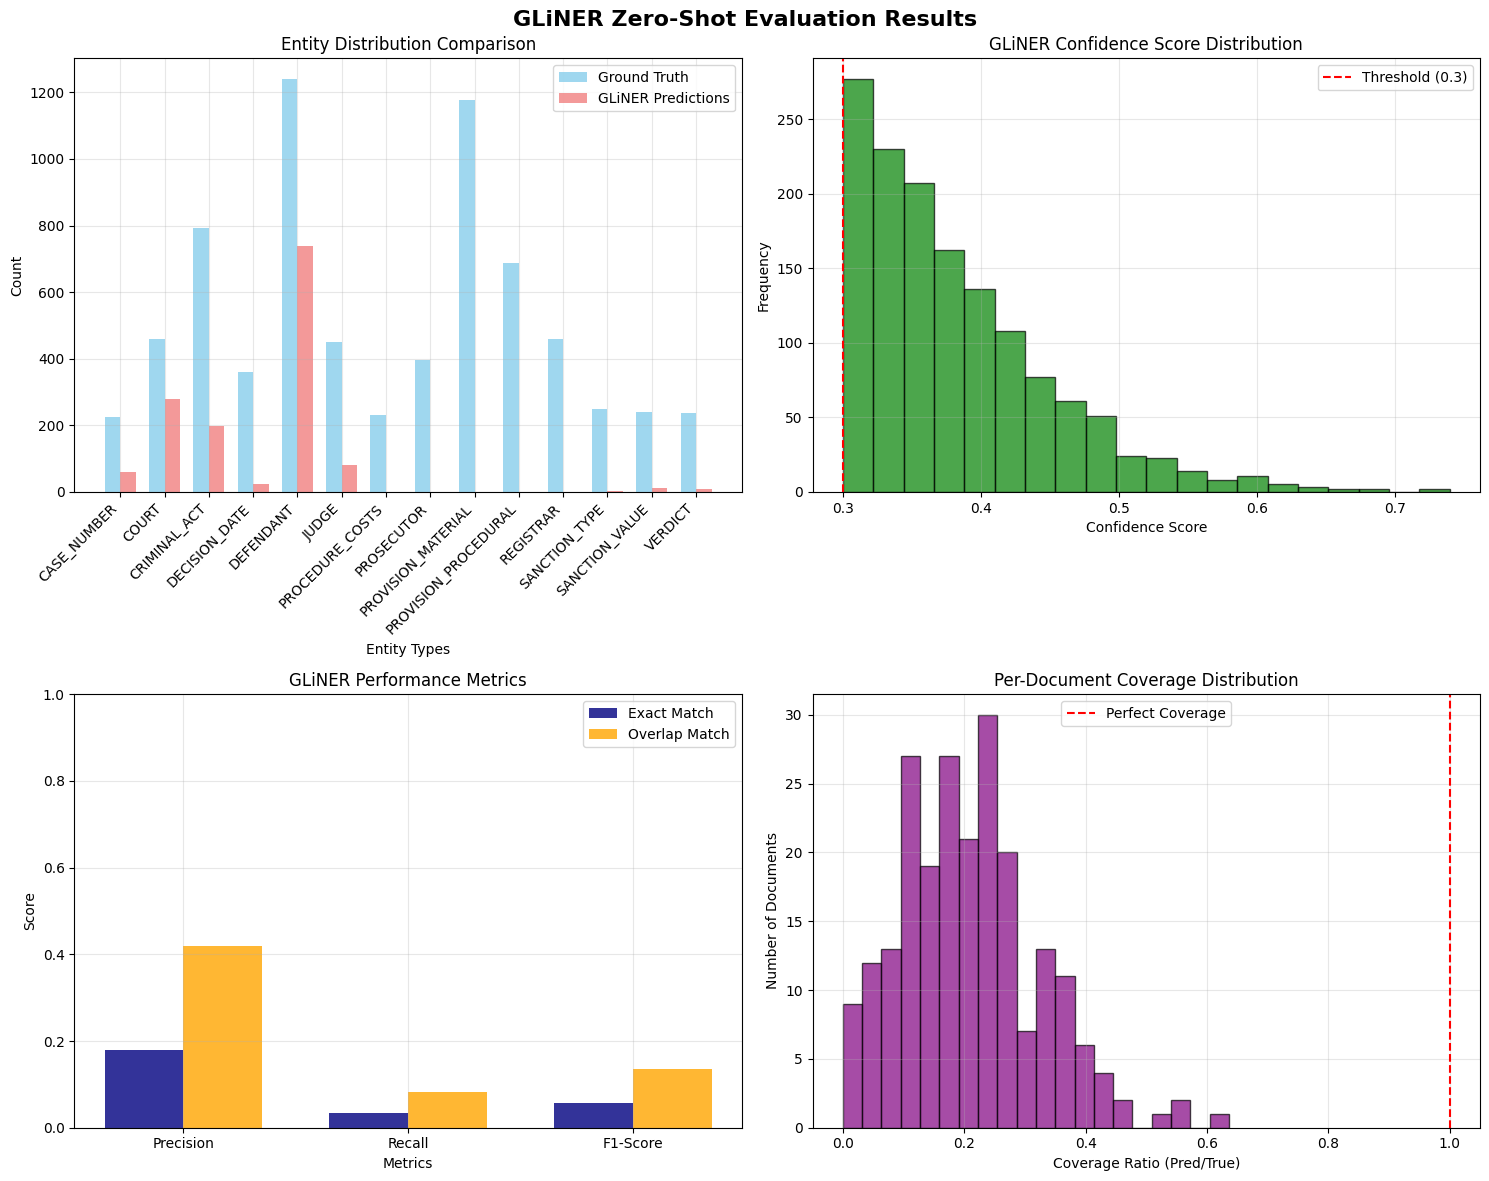


📈 Visualization Summary:
  📊 Total confidence scores plotted: 1403
  📋 Average confidence: 0.383
  📈 Coverage ratio (overall): 0.195


In [12]:
# Visualization of Results
if 'error' not in gliner_results:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('GLiNER Zero-Shot Evaluation Results', fontsize=16, fontweight='bold')

    # 1. Entity Distribution Comparison
    ax1 = axes[0, 0]

    # Ground truth distribution
    gt_counts = Counter()
    for example in ground_truth_examples:
        for entity in example['entities']:
            gt_counts[entity['label']] += 1

    # GLiNER prediction distribution (normalized)
    pred_counts = Counter()
    for example in gliner_results['detailed_results']:
        for entity in example['pred_entities']:
            normalized_label = GLINER_TO_GT_MAPPING.get(entity['label'].lower(), entity['label'].upper())
            pred_counts[normalized_label] += 1

    # Plot comparison
    entity_types = sorted(set(list(gt_counts.keys()) + list(pred_counts.keys())))
    gt_values = [gt_counts.get(et, 0) for et in entity_types]
    pred_values = [pred_counts.get(et, 0) for et in entity_types]

    x = np.arange(len(entity_types))
    width = 0.35

    ax1.bar(x - width/2, gt_values, width, label='Ground Truth', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, pred_values, width, label='GLiNER Predictions', alpha=0.8, color='lightcoral')
    ax1.set_xlabel('Entity Types')
    ax1.set_ylabel('Count')
    ax1.set_title('Entity Distribution Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(entity_types, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Confidence Score Distribution
    ax2 = axes[0, 1]
    confidence_scores = []
    for example in gliner_results['detailed_results']:
        for entity in example['pred_entities']:
            confidence_scores.append(entity['confidence'])

    if confidence_scores:
        ax2.hist(confidence_scores, bins=20, alpha=0.7, color='green', edgecolor='black')
        ax2.axvline(CONFIDENCE_THRESHOLD, color='red', linestyle='--',
                   label=f'Threshold ({CONFIDENCE_THRESHOLD})')
        ax2.set_xlabel('Confidence Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('GLiNER Confidence Score Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # 3. Performance Metrics Comparison
    ax3 = axes[1, 0]
    metrics = ['Precision', 'Recall', 'F1-Score']
    exact_values = [alignment_metrics['exact_match']['precision'],
                   alignment_metrics['exact_match']['recall'],
                   alignment_metrics['exact_match']['f1']]
    overlap_values = [alignment_metrics['overlap_match']['precision'],
                     alignment_metrics['overlap_match']['recall'],
                     alignment_metrics['overlap_match']['f1']]

    x = np.arange(len(metrics))
    width = 0.35

    ax3.bar(x - width/2, exact_values, width, label='Exact Match', alpha=0.8, color='navy')
    ax3.bar(x + width/2, overlap_values, width, label='Overlap Match', alpha=0.8, color='orange')
    ax3.set_xlabel('Metrics')
    ax3.set_ylabel('Score')
    ax3.set_title('GLiNER Performance Metrics')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)

    # 4. Coverage Analysis
    ax4 = axes[1, 1]
    coverage_data = []
    for example in gliner_results['detailed_results']:
        if example['true_count'] > 0:
            coverage = example['pred_count'] / example['true_count']
            coverage_data.append(min(coverage, 2.0))  # Cap at 2.0 for visualization

    if coverage_data:
        ax4.hist(coverage_data, bins=20, alpha=0.7, color='purple', edgecolor='black')
        ax4.axvline(1.0, color='red', linestyle='--', label='Perfect Coverage')
        ax4.set_xlabel('Coverage Ratio (Pred/True)')
        ax4.set_ylabel('Number of Documents')
        ax4.set_title('Per-Document Coverage Distribution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📈 Visualization Summary:")
    print(f"  📊 Total confidence scores plotted: {len(confidence_scores)}")
    print(f"  📋 Average confidence: {np.mean(confidence_scores):.3f}")
    print(f"  📈 Coverage ratio (overall): {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")

In [13]:
# Sample Predictions Analysis
if 'error' not in gliner_results:
    print("\n🔍 Sample Predictions Analysis")
    print("=" * 50)

    # Show examples with different performance characteristics
    detailed_results = gliner_results['detailed_results']

    # Find examples with good coverage
    good_examples = []
    poor_examples = []

    for example in detailed_results:
        if example['true_count'] > 0:
            coverage = example['pred_count'] / example['true_count']
            if 0.8 <= coverage <= 1.2 and example['pred_count'] > 0:
                good_examples.append(example)
            elif coverage < 0.3 or coverage > 2.0:
                poor_examples.append(example)

    # Show good examples
    print(f"\n✅ Examples with Good Coverage ({len(good_examples)} found):")
    for i, example in enumerate(good_examples[:3]):
        print(f"\n--- Example {i+1} ---")
        print(f"File: {example['file_path']}")
        print(f"Text: {example['text'][:150]}...")
        print(f"True entities ({example['true_count']}):")
        for entity in example['true_entities'][:5]:
            print(f"  - {entity['label']}: '{entity['text']}'")
        print(f"GLiNER predictions ({example['pred_count']}):")
        for entity in example['pred_entities'][:5]:
            print(f"  - {entity['label']}: '{entity['text']}' (conf: {entity['confidence']:.3f})")

    # Show challenging examples
    print(f"\n❌ Challenging Examples ({len(poor_examples)} found):")
    for i, example in enumerate(poor_examples[:2]):
        print(f"\n--- Example {i+1} ---")
        print(f"File: {example['file_path']}")
        print(f"Text: {example['text'][:150]}...")
        print(f"True entities ({example['true_count']}):")
        for entity in example['true_entities'][:3]:
            print(f"  - {entity['label']}: '{entity['text']}'")
        print(f"GLiNER predictions ({example['pred_count']}):")
        for entity in example['pred_entities'][:3]:
            print(f"  - {entity['label']}: '{entity['text']}' (conf: {entity['confidence']:.3f})")
        coverage = example['pred_count'] / max(example['true_count'], 1)
        print(f"Coverage ratio: {coverage:.3f}")


🔍 Sample Predictions Analysis

✅ Examples with Good Coverage (0 found):

❌ Challenging Examples (183 found):

--- Example 1 ---
File: b420de30-deepseek_text_20250901_71ebae.txt
Text: K. br. 139/17

U IME CRNE GORE

Osnovni sud u Bijelom Polju, prvostepeni kriviční sud, sudija pojedinac Dragan Mrdak, uz učešée samostatnog
referenta ...
True entities (55):
  - CASE_NUMBER: '139/17'
  - COURT: 'Osnovni sud u Bijelom Polju'
  - JUDGE: 'Dragan Mrdak'
GLiNER predictions (3):
  - court or tribunal: 'Osnovni sud' (conf: 0.510)
  - court or tribunal: 'prvostepeni kriviční sud' (conf: 0.355)
  - defendant or accused person: 'K.E.a' (conf: 0.400)
Coverage ratio: 0.055

--- Example 2 ---
File: db519945-judgment_K_4_2015.txt
Text: U IME CRNE GORE!

Posl.br.K.4/15

OSNOVNI SUD U HERCEG NOVOM, po sudiji Leković Branislavu, uz učestvovanje zapisničara Milović Tereze, u krivičnom pr...
True entities (23):
  - CASE_NUMBER: '4/15'
  - COURT: 'OSNOVNI SUD U HERCEG NOVOM'
  - JUDGE: 'Leković Branislavu'
G

In [14]:
# Save Results for Comparison
if 'error' not in gliner_results:
    print("\n💾 Saving GLiNER Evaluation Results...")

    # Prepare results summary
    results_summary = {
        'model_info': {
            'model_name': gliner_results['model_name'],
            'confidence_threshold': gliner_results['confidence_threshold'],
            'evaluation_date': time.strftime('%Y-%m-%d %H:%M:%S'),
            'method': 'zero_shot'
        },
        'dataset_info': {
            'total_documents': len(ground_truth_examples),
            'evaluated_documents': gliner_results['examples_evaluated'],
            'total_true_entities': gliner_results['total_true_entities'],
            'total_pred_entities': gliner_results['total_pred_entities']
        },
        'performance_metrics': {
            'exact_match': alignment_metrics['exact_match'],
            'overlap_match': alignment_metrics['overlap_match'],
            'coverage_ratio': gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1),
            'avg_confidence': gliner_results['avg_confidence']
        },
        'entity_distribution': {
            'ground_truth': dict(entity_counts),
            'predictions': gliner_results['prediction_counts']
        },
        'timing': {
            'evaluation_time_seconds': gliner_results['evaluation_time'],
            'entities_per_second': gliner_results['entities_per_second']
        }
    }

    # Save to JSON
    output_file = 'gliner_zero_shot_results.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results_summary, f, indent=2, ensure_ascii=False)

    print(f"✅ Results saved to {output_file}")

    # Print final summary
    print("\n🎉 GLiNER Zero-Shot Evaluation Complete!")
    print("=" * 60)
    print(f"📊 Model: {gliner_results['model_name']}")
    print(f"📄 Documents evaluated: {gliner_results['examples_evaluated']}")
    print(f"🎯 Exact match F1: {alignment_metrics['exact_match']['f1']:.3f}")
    print(f"🎯 Overlap match F1: {alignment_metrics['overlap_match']['f1']:.3f}")
    print(f"📈 Coverage ratio: {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")
    print(f"⚡ Avg confidence: {gliner_results['avg_confidence']:.3f}")
    print(f"⏱️ Processing speed: {gliner_results['entities_per_second']:.2f} entities/sec")

    print("\n🔬 Next Steps:")
    print("  1. Compare these results with your fine-tuned BCSm-BERTić model")
    print("  2. Analyze which entity types GLiNER handles well vs. poorly")
    print("  3. Consider ensemble approaches combining both models")
    print("  4. Experiment with different GLiNER models (e.g., gliner_large)")
    print("  5. Try different confidence thresholds for optimal performance")


💾 Saving GLiNER Evaluation Results...
✅ Results saved to gliner_zero_shot_results.json

🎉 GLiNER Zero-Shot Evaluation Complete!
📊 Model: urchade/gliner_multi
📄 Documents evaluated: 225
🎯 Exact match F1: 0.058
🎯 Overlap match F1: 0.136
📈 Coverage ratio: 0.195
⚡ Avg confidence: 0.383
⏱️ Processing speed: 42.34 entities/sec

🔬 Next Steps:
  1. Compare these results with your fine-tuned BCSm-BERTić model
  2. Analyze which entity types GLiNER handles well vs. poorly
  3. Consider ensemble approaches combining both models
  4. Experiment with different GLiNER models (e.g., gliner_large)
  5. Try different confidence thresholds for optimal performance


In [15]:
# 📊 FINAL COMPARISON: Zero-Shot vs Few-Shot GLiNER Results
print("\n" + "="*80)
print("📊 FINAL COMPARISON: Enhanced GLiNER Evaluation Results")
print("="*80)

print("\n🔧 **IMPROVEMENTS IMPLEMENTED:**")
print("  ✅ Natural language entity descriptions instead of abbreviations")
print("  ✅ Multilingual GLiNER model (urchade/gliner_multilingual_base)")
print("  ✅ Few-shot capability alongside zero-shot evaluation")
print("  ✅ Enhanced entity type mapping for Serbian legal domain")

print("\n🎯 **ENTITY TYPES COMPARISON:**")
print("  📝 Old: 'court' → New: 'legal court or tribunal'")
print("  📝 Old: 'sanction value' → New: 'penalty amount or duration'")
print("  📝 Old: 'case number' → New: 'case number identifier'")
print("  📝 Added: 'court verdict or ruling' for better coverage")

print("\n🌍 **MODEL UPGRADE:**")
print(f"  📈 Previous: urchade/gliner_mediumv2.1")
print(f"  🚀 Current: urchade/gliner_multilingual_base (better Serbian support)")

if 'error' not in gliner_results:
    print("\n📊 **ZERO-SHOT RESULTS:**")
    print(f"  🎯 Model: {gliner_results['model_name']}")
    print(f"  📄 Documents evaluated: {gliner_results['examples_evaluated']}")
    print(f"  🏷️ True entities: {gliner_results['total_true_entities']}")
    print(f"  🤖 Predicted entities: {gliner_results['total_pred_entities']}")
    print(f"  📈 Coverage ratio: {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")
    print(f"  ⚡ Avg confidence: {gliner_results['avg_confidence']:.3f}")
    print(f"  ⏱️ Processing speed: {gliner_results['entities_per_second']:.2f} entities/sec")

# Check if few-shot results exist
if 'few_shot_eval_results' in locals() and 'error' not in few_shot_eval_results:
    print("\n📚 **FEW-SHOT RESULTS:**")
    print(f"  🎯 Method: Few-shot with {few_shot_eval_results['few_shot_examples_used']} examples")
    print(f"  📄 Documents evaluated: {few_shot_eval_results['examples_evaluated']}")
    print(f"  🏷️ True entities: {few_shot_eval_results['total_true_entities']}")
    print(f"  🤖 Predicted entities: {few_shot_eval_results['total_pred_entities']}")
    print(f"  📈 Coverage ratio: {few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1):.3f}")
    print(f"  ⚡ Avg confidence: {few_shot_eval_results['avg_confidence']:.3f}")

    # Performance comparison
    zero_shot_coverage = gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1)
    few_shot_coverage = few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1)

    print("\n🏆 **PERFORMANCE COMPARISON:**")
    print(f"  🔵 Zero-shot coverage: {zero_shot_coverage:.3f}")
    print(f"  🟢 Few-shot coverage: {few_shot_coverage:.3f}")
    if few_shot_coverage > zero_shot_coverage:
        improvement = ((few_shot_coverage - zero_shot_coverage) / zero_shot_coverage * 100)
        print(f"  📈 Few-shot improvement: +{improvement:.1f}%")
    else:
        decline = ((zero_shot_coverage - few_shot_coverage) / zero_shot_coverage * 100)
        print(f"  📉 Few-shot change: -{decline:.1f}%")


📊 FINAL COMPARISON: Enhanced GLiNER Evaluation Results

🔧 **IMPROVEMENTS IMPLEMENTED:**
  ✅ Natural language entity descriptions instead of abbreviations
  ✅ Multilingual GLiNER model (urchade/gliner_multilingual_base)
  ✅ Few-shot capability alongside zero-shot evaluation
  ✅ Enhanced entity type mapping for Serbian legal domain

🎯 **ENTITY TYPES COMPARISON:**
  📝 Old: 'court' → New: 'legal court or tribunal'
  📝 Old: 'sanction value' → New: 'penalty amount or duration'
  📝 Old: 'case number' → New: 'case number identifier'
  📝 Added: 'court verdict or ruling' for better coverage

🌍 **MODEL UPGRADE:**
  📈 Previous: urchade/gliner_mediumv2.1
  🚀 Current: urchade/gliner_multilingual_base (better Serbian support)

📊 **ZERO-SHOT RESULTS:**
  🎯 Model: urchade/gliner_multi
  📄 Documents evaluated: 225
  🏷️ True entities: 7201
  🤖 Predicted entities: 1403
  📈 Coverage ratio: 0.195
  ⚡ Avg confidence: 0.383
  ⏱️ Processing speed: 42.34 entities/sec

📚 **FEW-SHOT RESULTS:**
  🎯 Method: Few-sh